In [15]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import datetime as dt
import re

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from yellowbrick.regressor import ResidualsPlot

In [16]:
# import csv, some clean up
wiki_feat = pd.read_csv('../ExtractClean/wiki_10feat.csv')
wiki_feat = wiki_feat.set_index('article_name') #set article name as index

wiki_nlp = pd.read_csv('../NLP/wiki_nlp.csv')
wiki_nlp = wiki_nlp.rename(columns={'this_article_unique_name': 'article_name'})
wiki_nlp.drop(columns=['Unnamed: 0'], inplace=True)
wiki_nlp = wiki_nlp.set_index('article_name') #set article name as index
wiki_nlp = wiki_nlp.reset_index()
wiki_nlp.fillna(value = 0, inplace=True)

In [17]:
# clean up wiki_feat more
wiki_feat.drop(columns=['date_article_creation'], inplace=True, errors='ignore')
cols = wiki_feat.columns.tolist()
wiki_feat_columns = ['languages', 'references', 'text_length', 'main_article_num', 'see_also_num', 'table_text_len', 'sports', 'wiki_link_num', 'days_since_creation']
wiki_feat = wiki_feat.reindex(columns=wiki_feat_columns)
wiki_feat = wiki_feat.reset_index()
wiki_feat = wiki_feat.rename(columns={'languages': 'lang_total_num_targt','references': 'ref_total_num_feat','sports':'sports_bool'})
wiki_feat.drop(columns=['level_0'], inplace=True, errors='ignore')

# clean up wiki_nlp more
wiki_nlp.drop(columns=['level_0'], inplace=True, errors='ignore')

In [18]:
wiki_comb = wiki_feat.merge(wiki_nlp, left_on='article_name', right_on='article_name')
wiki_comb = wiki_comb.reset_index()
wiki_comb.set_index('article_name', inplace=True) #set article name as index
wiki_comb.drop(['1858', 'Ice','Dysprosium','Eucalyptus','.uy','2000s in music'], inplace=True, errors='ignore') #outliers 

In [19]:
# add interacting terms from the terms that were kept from lasso transformation with only the 10 features
wiki_comb['table_text_len^2'] = wiki_comb['table_text_len']**2
wiki_comb['table_text_len * wiki_link_num'] = wiki_comb['table_text_len'] * wiki_comb['wiki_link_num']
wiki_comb['sports_bool^2'] = wiki_comb['sports_bool']**2
wiki_comb = wiki_comb.reset_index()
wiki_comb.set_index('article_name', inplace=True) #set article name as index

In [20]:
#normalize all features except languages
normalized_wiki_comb = (wiki_comb - wiki_comb.min()) / (wiki_comb.max()-wiki_comb.min())
normalized_wiki_comb['lang_total_num_targt'] = wiki_comb['lang_total_num_targt']

In [21]:
# wiki_comb.loc[wiki_comb['article_name'] == 'Miami Hurricanes football']
# wiki_comb.iloc[45]
wiki_comb.head()

,level_0,lang_total_num_targt,ref_total_num_feat,text_length,main_article_num,see_also_num,table_text_len,sports_bool,wiki_link_num,days_since_creation,...,calcutta,kmc,bahrenborstel,diepholz,redmond,biologist,obe,table_text_len^2,table_text_len * wiki_link_num,sports_bool^2
article_name,,,,,,,,,,,,,,,,,,,,,
"Sérgio Pinto (footballer, born 1973)",0,1,3,2666,0,0,618,1,102,4213.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,381924,63036,1
Bradley Jennings,1,2,6,3184,0,0,1176,1,74,2553.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1382976,87024,1
Progressive Canadian Party,2,1,3,11911,0,1,6080,0,105,6035.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36966400,638400,0
2-Heptanone,3,11,15,6801,0,0,1667,0,93,4647.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2778889,155031,0
Michael Yano,4,20,2,2219,0,0,913,1,106,3813.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,833569,96778,1


In [22]:
# Create an empty model
lr_full = LinearRegression()

# Features
X = wiki_comb.loc[:, 'ref_total_num_feat':"sports_bool^2"]

# Target
y = wiki_comb['lang_total_num_targt']

In [23]:
# Fit  
lr_full.fit(X, y)

# Score
lr_full.score(X, y)

0.9997966716746073

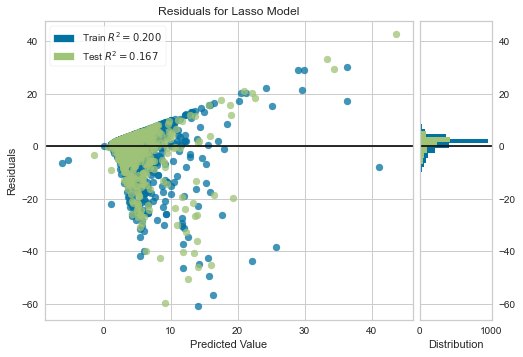

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7fcda904de50&gt;

In [48]:
# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Instantiate the linear model and visualizer
model = Lasso(alpha=20)
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [30]:
model.fit(X_train, y_train)
prediction = model.predict(X_test)
residual = abs(y_test - prediction)

residual.sort_values(ascending=False).head(20)

article_name
Pope Nicholas II                                  47.972812
Mondragone                                        39.732263
Cerro Largo Department                            39.543921
Manfred Eigen                                     39.219390
Immigration to the United States                  36.256363
Jiroemon Kimura                                   31.740382
Isanti County, Minnesota                          29.224303
Suizhou                                           27.432529
Commerce City, Colorado                           25.428126
List of minor planets: 64001–65000                25.029256
St Mirren F.C.                                    25.012737
Italy national football team results (2010–29)    24.968457
Medrogestone                                      24.418209
Poor Folk                                         24.371745
Ittlingen                                         23.712865
Outline of Serbia                                 22.492128
West Liberty, Iowa         